Ce notebook contient la partie 1 sur la classification binaire non supervisée. La méthode utilisée ici est de créer un auto encodeur et d'ensuite faire du clustering, de la classification non supervisée.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:
DRIVE_PATH = '/home/procope/ProjetHDDL/'
TEST_LIST_DIR = os.path.join(DRIVE_PATH, 'annotations')
IMAGE_DIR = os.path.join(DRIVE_PATH, 'images')
ANNOTATION_FILE = os.path.join(TEST_LIST_DIR, 'list.txt')
TEST_LIST_FILE = os.path.join(TEST_LIST_DIR, 'test.txt')

In [3]:
print(TEST_LIST_FILE)

/home/procope/ProjetHDDL/annotations/test.txt


In [7]:
import os
import torch
from torch.utils.data import Subset, random_split, DataLoader


def create_data_splits(full_dataset, test_list_path, val_ratio=0.1):
    """
    Sépare le jeu de données en Train/Validation/Test, le Test étant défini
    par un fichier de liste
    """
    test_filenames = set()
    try:
        with open(test_list_path, 'r') as f:
            for line in f:
                if line.startswith('#') or not line.strip():
                    continue

                parts = line.strip().split()

                if not parts:
                    continue
                image_filename_base = parts[0] + ".jpg"
                test_filenames.add(image_filename_base)

    except FileNotFoundError:
        print(f"ERREUR: Fichier de liste de test non trouvé à {test_list_path}. Retourne des Subsets vides.")
        return None, None, None

    test_indices = []
    train_val_indices = []

    for i, (full_path, _) in enumerate(full_dataset.data):
        filename = os.path.basename(full_path)
        if filename in test_filenames:
            test_indices.append(i)
        else:
            train_val_indices.append(i)

    print(f"Indices identifiés : Train/Val = {len(train_val_indices)} | Test = {len(test_indices)}")

    if not train_val_indices or not test_indices:
         print("Attention : un ou plusieurs ensembles sont vides. Vérifiez le fichier de test.")


    test_subset = Subset(full_dataset, test_indices)

    train_val_size = len(train_val_indices)
    val_size = int(val_ratio * train_val_size)
    train_size = train_val_size - val_size

    train_val_subset = Subset(full_dataset, train_val_indices)
    train_subset, val_subset = random_split(
        train_val_subset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    return train_subset, val_subset, test_subset

# PARTIE 2 : Classification binaire plus poussée

Classification sans label : Utilisation d'auto encodeurs

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

DRIVE_PATH = '/home/procope/ProjetHDDL/'
IMAGE_DIR = os.path.join(DRIVE_PATH, 'images') 
ANNOTATION_FILE = os.path.join(DRIVE_PATH, 'annotations', 'list.txt')

class OxfordDatasetBinary(Dataset):
    """
    Jeu de données pour la classification standard (1 image et 1 label par échantillon).
    """
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.classes = []
        self.data = self._load_data(annotation_file)

        print(f"Dataset initialisé. Nombre total d'échantillons: {len(self.data)}")


    def _load_data(self, annotation_file):
        """
        Analyse le fichier d'annotation au format Oxford-IIIT Pet (Image CLASS-ID SPECIES BREED ID).
        Utilise le CLASS-ID comme étiquette de classification.
        """
        data_list = []
        label_to_index = {}
        index_counter = 0

        try:
            with open(annotation_file, 'r') as f:
                for line in f:
                    if line.startswith('#') or not line.strip():
                        continue

                    parts = line.strip().split()
                    if len(parts) < 4:
                        print(f"Ligne ignorée (format incorrect): {line.strip()}")
                        continue

                    image_filename = parts[0] + ".jpg" 
                    class_id_str = parts[2]            
                    if class_id_str not in label_to_index:
                        label_to_index[class_id_str] = index_counter
                        self.classes.append(class_id_str)
                        index_counter += 1

                    label_index = label_to_index[class_id_str]
                    full_image_path = os.path.join(self.image_dir, image_filename)
                    if not os.path.exists(full_image_path):
                         full_image_path = os.path.join(self.image_dir, parts[0])

                         if not os.path.exists(full_image_path):
                            pass

                    data_list.append((full_image_path, label_index))

        except FileNotFoundError:
             print(f"ERREUR: Fichier d'annotation non trouvé à {annotation_file}.")
             return []

        return data_list

    def __len__(self):
        """ Retourne le nombre total d'échantillons. """
        return len(self.data)

    def __getitem__(self, idx):
        """ Récupère un échantillon à l'index donné: (image, label_index). """
        img_path, label_index = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label_index, dtype=torch.long)

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

full_dataset_type = OxfordDatasetBinary(
    image_dir=IMAGE_DIR,
    annotation_file=ANNOTATION_FILE,
    transform=eval_transforms 
)

train_subset, val_subset_train_tf, test_subset_train_tf = create_data_splits(
    full_dataset=full_dataset_type,
    test_list_path=TEST_LIST_FILE,
    val_ratio=0.1
)

if val_subset_train_tf and test_subset_train_tf:
    val_indices = val_subset_train_tf.indices
    test_indices = test_subset_train_tf.indices

    val_subset = Subset(full_dataset_type, val_indices)
    test_subset = Subset(full_dataset_type, test_indices)
else:

    val_subset, test_subset = None, None

batch_size = 32

if train_subset and val_subset and test_subset:
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, pin_memory=True)

    print("\n--- DataLoaders Créés avec Succès ---")
    print(f"Train Samples: {len(train_subset)} ({len(train_dataloader)} batches) - Transformations d'entraînement.")
    print(f"Validation Samples: {len(val_subset)} ({len(val_dataloader)} batches) - Transformations d'évaluation.")
    print(f"Test Samples: {len(test_subset)} ({len(test_dataloader)} batches) - Transformations d'évaluation.")
else:
     print("Échec de la création des DataLoaders en raison d'une erreur dans la division des données.")

Dataset initialisé. Nombre total d'échantillons: 7349
Indices identifiés : Train/Val = 3680 | Test = 3669

--- DataLoaders Créés avec Succès ---
Train Samples: 3312 (104 batches) - Transformations d'entraînement.
Validation Samples: 368 (12 batches) - Transformations d'évaluation.
Test Samples: 3669 (115 batches) - Transformations d'évaluation.


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
from torchsummary import summary

In [12]:
from tqdm import tqdm
#from tqdm.notebook import tqdm

In [13]:
from sklearn.manifold import TSNE
from scipy.stats import norm

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [15]:

n_input = 3 * 224 * 224
n_latent = 32

## Méthodes d auto encodeur sans préentrainement

Auto Encodeur Conv deep

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.conv = DoubleConv(out_channels, out_channels)

    def forward(self, x1, x2=None): 
        x1 = self.up(x1)

        return self.conv(x1)

In [ ]:
class CAESymmetric(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        features = [64, 128, 256, 512]

        self.inc = DoubleConv(in_channels, features[0])
        self.down1 = Down(features[0], features[1])
        self.down2 = Down(features[1], features[2])
        self.down3 = Down(features[2], features[3])
        self.down4 = Down(features[3], features[3] * 2) 

        self.up1 = Up(features[3] * 2, features[3])
        self.up2 = Up(features[3], features[2])
        self.up3 = Up(features[2], features[1])
        self.up4 = Up(features[1], features[0])

        self.outc = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x) 

        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)

        return self.outc(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE_TO_USE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 1e-4

def train_cae(model, train_dataloader, val_dataloader, epochs, device=DEVICE_TO_USE, lr=LEARNING_RATE):
    model.to(device)
    history = {'train_loss': [], 'val_loss': []}
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"Démarrage de l'entraînement du CAE sur {epochs} époques avec un learning rate de {lr}")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} (Train CAE)")

        for inputs, _ in train_loop:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_dataloader.dataset)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, _ in val_dataloader:
                inputs = inputs.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, inputs)

                val_loss += loss.item() * inputs.size(0)

        avg_val_loss = val_loss / len(val_dataloader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    print("\nEntraînement CAE terminé.")
    return model, history



In [ ]:
cae_model = CAESymmetric(in_channels=3, out_channels=3)

cae_model, loss_history = train_cae(
         cae_model,
        train_dataloader, 
         val_dataloader,   
        epochs=50       
   )


Démarrage de l'entraînement du CAE sur 50 époques avec un learning rate de 0.0001


Epoch 1/50 (Train CAE): 100%|██████████| 104/104 [01:33<00:00,  1.11it/s, loss=0.0439]


Epoch 1/50 | Train Loss: 0.128258 | Val Loss: 0.041009


Epoch 2/50 (Train CAE): 100%|██████████| 104/104 [01:22<00:00,  1.27it/s, loss=0.0152]


Epoch 2/50 | Train Loss: 0.025117 | Val Loss: 0.017979


Epoch 3/50 (Train CAE):  55%|█████▍    | 57/104 [00:45<00:37,  1.25it/s, loss=0.0143]


KeyboardInterrupt: 

In [ ]:
model_to_save = cae_model
file_path = '/content/drive/MyDrive/Projet_HDDL/modele_cae_50epoch.pt'

torch.save(model_to_save.state_dict(), file_path)

print(f"Modèle sauvegardé : {file_path}")

In [ ]:
def check_device_model(model, device):
    current_device = next(model.parameters()).device
    if current_device != torch.device(device):
        model.to(device)
    return model


# --- #

def select_n_samples(laoder, n, device):
    dataset = laoder.dataset
    indices = torch.randperm(len(dataset))[:n]
    inputs_list = [dataset[i][0].unsqueeze(0) for i in indices]
    inputs = torch.cat(inputs_list, dim=0).to(device)
    return inputs


# --- #

def visualize_autoencoder(autoencoder,
                          loader = test_dataloader,
                          input_sz = (224,224),
                          latent_sz = (4,8),
                          n = 10,
                          device = device
                         ):

    autoencoder = check_device_model(autoencoder, device=device)
    autoencoder.eval()

    inputs = select_n_samples(laoder=loader, n=n, device=device) 
    inputs_flat = inputs.view(inputs.size(0), -1)                 

    with torch.no_grad():
        encoded = autoencoder.encoder(inputs_flat)
        decoded = autoencoder.decoder(encoded)

    plot_images(
        imgs = [inputs, encoded, decoded],
        sz = [input_sz, latent_sz, input_sz],
        titles = ['Original', 'Encoded', 'Decoded'],
        n = n
    )

In [ ]:
import torch

DEVICE_TO_USE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FILE_PATH = '/home/procope/ProjetHDDL/modele_cae_50epoch.pt'

def load_cae_autoencoder(file_path, device=DEVICE_TO_USE):

    loaded_model = CAESymmetric(in_channels=3, out_channels=3)
    try:
        state_dict = torch.load(file_path, map_location=device)
    except FileNotFoundError:
        print(f"Erreur: Fichier non trouvé à l'emplacement {file_path}. Veuillez vérifier le chemin.")
        return None

    try:
        loaded_model.load_state_dict(state_dict)
    except RuntimeError as e:
        print(f"Erreur de chargement de state_dict. Cela peut être dû à une désynchronisation des architectures.")
        print(f"Détails de l'erreur: {e}")

        return None

    loaded_model.to(device)
    loaded_model.eval()

    print(f"Modèle UNet Autoencoder chargé avec succès depuis {file_path}")
    return loaded_model


In [21]:
cae_model = load_cae_autoencoder(FILE_PATH)
FILE_PATH = '/home/procope/ProjetHDDL/modele_cae_100epoch.pt'
cae_model2 = load_cae_autoencoder(FILE_PATH)

Modèle UNet Autoencoder chargé avec succès depuis /home/procope/ProjetHDDL/modele_cae_50epoch.pt
Modèle UNet Autoencoder chargé avec succès depuis /home/procope/ProjetHDDL/modele_cae_100epoch.pt


In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_cae(autoencoder, loader, n=6):
    """
    Visualisation pour autoencodeur convolutionnel (CAESymmetric)
    CPU / GPU safe
    """

    device = next(autoencoder.parameters()).device
    autoencoder.eval()

    inputs = select_n_samples(laoder=loader, n=n, device=device)

    with torch.no_grad():
        x = autoencoder.inc(inputs)
        x = autoencoder.down1(x)
        x = autoencoder.down2(x)
        x = autoencoder.down3(x)
        bottleneck = autoencoder.down4(x)
        decoded = autoencoder(inputs)
    bottleneck_vis = bottleneck.mean(dim=1)

    inputs = inputs.cpu()
    decoded = decoded.cpu()
    bottleneck_vis = bottleneck_vis.cpu()

    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))

    for i in range(n):
        axes[0, i].imshow(inputs[i].permute(1, 2, 0))
        axes[0, i].axis("off")
        axes[1, i].imshow(bottleneck_vis[i], cmap="viridis")
        axes[1, i].axis("off")

        axes[2, i].imshow(decoded[i].permute(1, 2, 0))
        axes[2, i].axis("off")

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Bottleneck")
    axes[2, 0].set_ylabel("Decoded")

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.044071645..1.0656965].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00712429..0.95873797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03369534..1.0254927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.014334723..1.0730419].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.017304614..1.0617585].


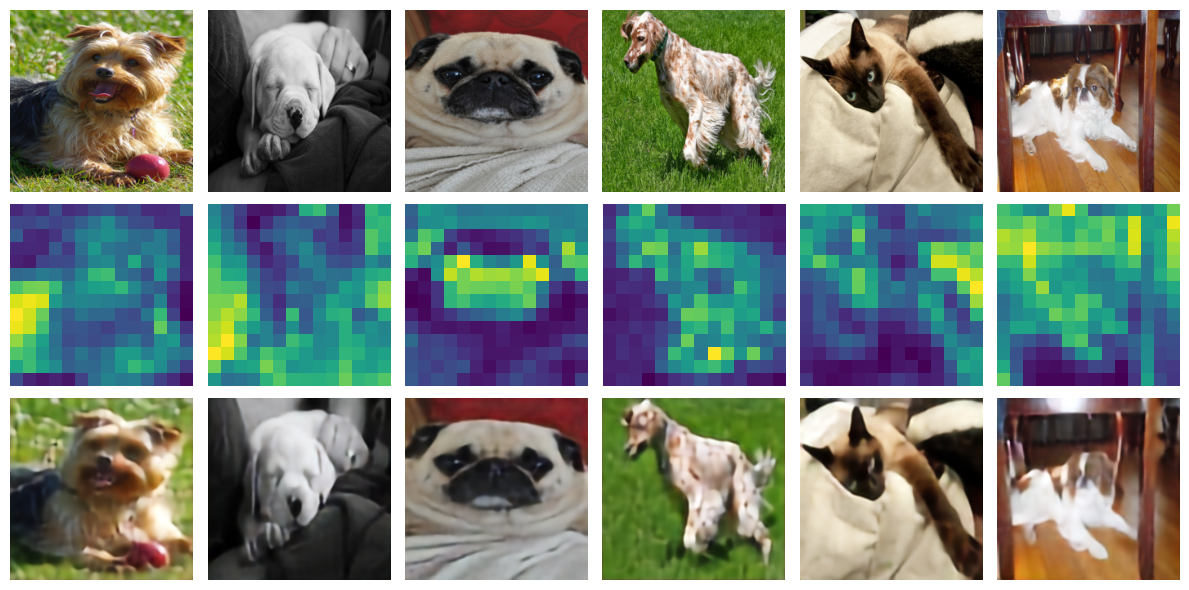

In [43]:
visualize_cae(cae_model2,test_dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026287094..1.001572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.036787353..1.1070839].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050591193..1.0602764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.038995244..1.0919093].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003988728..1.0546983].


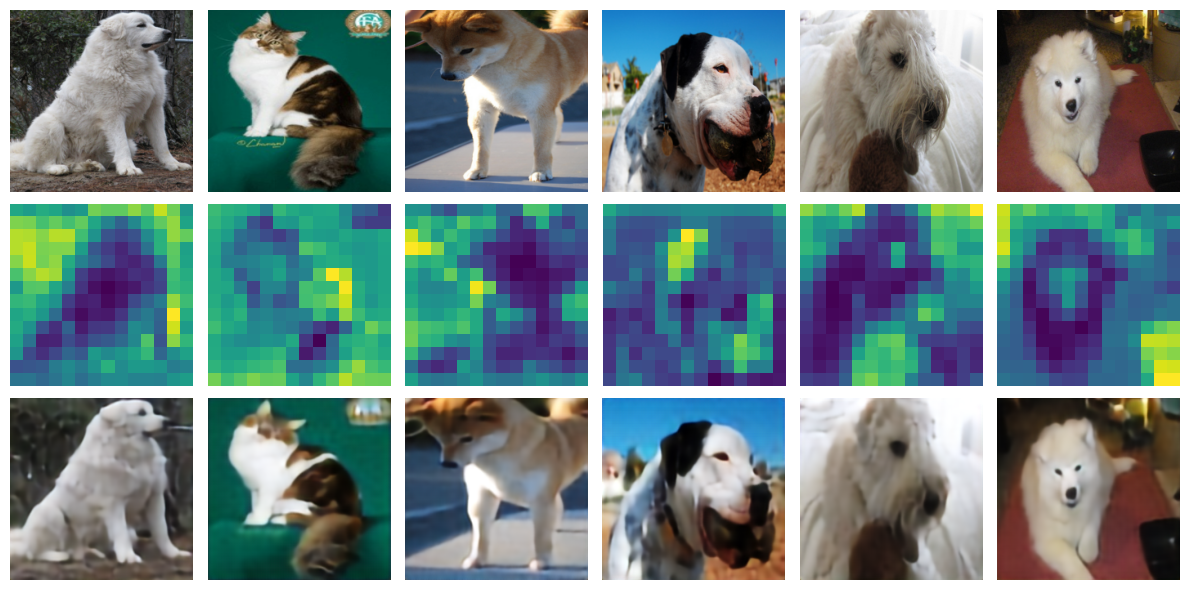

In [30]:
visualize_cae(cae_model2,test_dataloader)

In [ ]:
import torch
from torch.utils.data import DataLoader

def extract_latent_features_cae(autoencoder, dataset, batch_size=64):
    """
    Extraction des features latentes depuis le bottleneck d'un CAE
    """

    device = next(autoencoder.parameters()).device
    autoencoder.eval()

    latent_features_list = []
    true_labels_list = []

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            x = autoencoder.inc(inputs)
            x = autoencoder.down1(x)
            x = autoencoder.down2(x)
            x = autoencoder.down3(x)
            bottleneck = autoencoder.down4(x)
            flattened_features = bottleneck.view(bottleneck.size(0), -1)

            latent_features_list.append(flattened_features.cpu())
            true_labels_list.append(labels.cpu())

    all_latent_features = torch.cat(latent_features_list, dim=0)
    all_true_labels = torch.cat(true_labels_list, dim=0)

    return all_latent_features, all_true_labels


In [45]:
latent_features, true_labels = extract_latent_features_cae(
    cae_model2,
    full_dataset_type,
    batch_size=batch_size
)

print("Latent features shape:", latent_features.shape)
print("Labels shape:", true_labels.shape)


Latent features shape: torch.Size([7349, 200704])
Labels shape: torch.Size([7349])


In [ ]:
from torch.utils.data import Subset
import numpy as np

N = len(full_dataset_type)

subset_size = int(0.1 * N)  
indices = np.random.choice(N, subset_size, replace=False)

small_dataset = Subset(full_dataset_type, indices)


In [25]:
latent_features, true_labels = extract_latent_features_cae(
    cae_model2,
    small_dataset,
    batch_size=batch_size
)

print("Latent features shape:", latent_features.shape)
print("Labels shape:", true_labels.shape)


Latent features shape: torch.Size([734, 200704])
Labels shape: torch.Size([734])


In [26]:
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

2. Application de K-Means (K=2) pour le clustering...
3. Réduction de dimension avec t-SNE pour la visualisation...
4. Vérification et visualisation des clusters...

Qualité du Clustering (comparé aux vrais labels - ARI): 0.0005


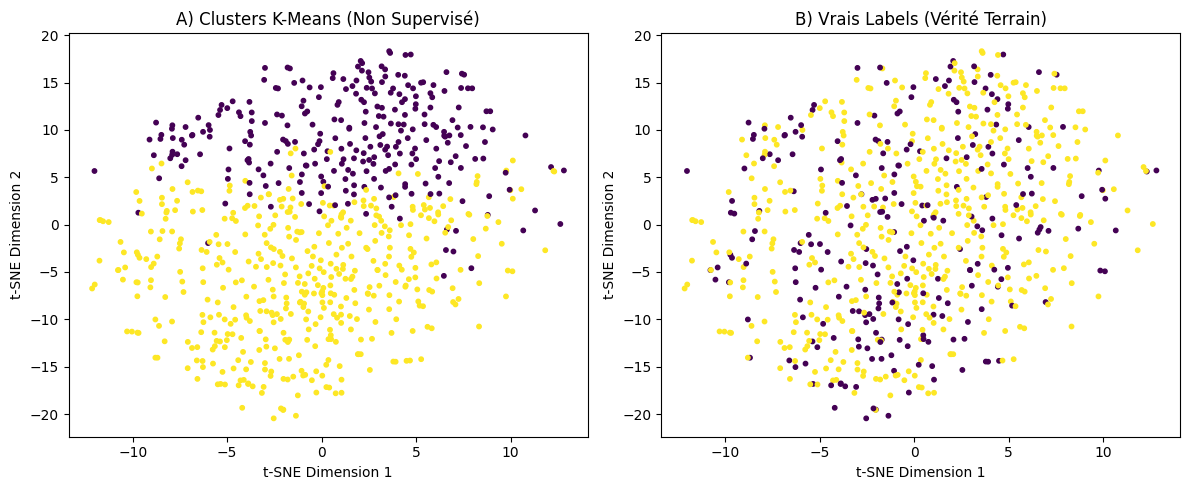

In [ ]:
N_CLUSTERS = 2
print(f"2. Application de K-Means (K={N_CLUSTERS}) pour le clustering...")
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10, random_state=42)
kmeans.fit(latent_features)
cluster_labels = kmeans.labels_all
print("3. Réduction de dimension avec t-SNE pour la visualisation...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latents_2d = tsne.fit_transform(latent_features)

print("4. Vérification et visualisation des clusters...")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('A) Clusters K-Means (Non Supervisé)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
if true_labels is not None:
    plt.subplot(1, 2, 2)
    plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=true_labels.numpy(), cmap='viridis', s=10)
    plt.title('B) Vrais Labels (Vérité Terrain)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    from sklearn.metrics import adjusted_rand_score
    ari_score = adjusted_rand_score(true_labels.numpy(), cluster_labels)
    print(f"\nQualité du Clustering (comparé aux vrais labels - ARI): {ari_score:.4f}")

plt.tight_layout()
plt.show()


In [ ]:
model_to_save = cae_model
file_path = '/content/drive/MyDrive/Projet_HDDL/modele_cae_100epoch.pt'

# Sauvegarde de l'état du modèle (state_dict)
torch.save(model_to_save.state_dict(), file_path)

print(f"Modèle sauvegardé : {file_path}")

In [36]:
cae_model2, loss_history = train_cae(
         cae_model2,
        train_dataloader, # Assurez-vous d'avoir ce DataLoader
         val_dataloader,   # Assurez-vous d'avoir ce DataLoader
        epochs=50        # C'est une bonne base de départ pour un CAE
   )


Démarrage de l'entraînement du CAE sur 50 époques avec un learning rate de 0.0001


Epoch 1/50 (Train CAE): 100%|██████████| 104/104 [01:23<00:00,  1.25it/s, loss=0.00209]


Epoch 1/50 | Train Loss: 0.005620 | Val Loss: 0.002570


Epoch 2/50 (Train CAE):  38%|███▊      | 39/104 [00:31<00:53,  1.23it/s, loss=0.00234]

In [ ]:
model_to_save = cae_model2
file_path = '/content/drive/MyDrive/Projet_HDDL/modele_cae_150epoch.pt'

torch.save(model_to_save.state_dict(), file_path)

print(f"Modèle sauvegardé : {file_path}")

Avec les modèles sans pré-entrainement, l 'espace latent ne contient pas les caractéristiques nécessaires pour séparer les chats et les chiens. Nous nos sommes donc tournées vers des modèles préentrainé et me transfert learning

# Test Modèles Pré-entrainés

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


DEVICE_TO_USE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_CLUSTERS = 2  
weights = ResNet18_Weights.IMAGENET1K_V1
resnet = resnet18(weights=weights)

encoder = nn.Sequential(*(list(resnet.children())[:-1]))

for param in encoder.parameters():
    param.requires_grad = False
encoder.eval()
encoder.to(DEVICE_TO_USE)

print(f"Encodeur ResNet18 chargé. Dimension latente : 512.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 76.4MB/s]


Encodeur ResNet18 chargé. Dimension latente : 512.


In [ ]:
def extract_resnet_latents(encoder, dataset, batch_size=64, device=DEVICE_TO_USE):

    encoded_list = []
    labels_list = []

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch_data in loader:
            if isinstance(batch_data, (list, tuple)):
                inputs = batch_data[0].to(device)
                labels_list.append(batch_data[1])
            else:
                inputs = batch_data.to(device)

            latent_output = encoder(inputs)
            encoded_flat = latent_output.view(latent_output.size(0), -1)

            encoded_list.append(encoded_flat.cpu())

    all_latents = torch.cat(encoded_list)
    all_labels = torch.cat(labels_list) if labels_list else None

    return all_latents, all_labels

In [ ]:
# 1. Extraction des caractéristiques latentes (512D)
print("1. Extraction des vecteurs latents de 512D...")
latents_tensor, true_labels = extract_resnet_latents(encoder, full_dataset_type)
latents_np = latents_tensor.numpy()

1. Extraction des vecteurs latents de 512D...


KeyboardInterrupt: 

2. Application de K-Means (K=2) pour le clustering...
3. Réduction de dimension avec t-SNE pour la visualisation...
4. Vérification et visualisation des clusters...

Qualité du Clustering (comparé aux vrais labels - ARI): 0.7513


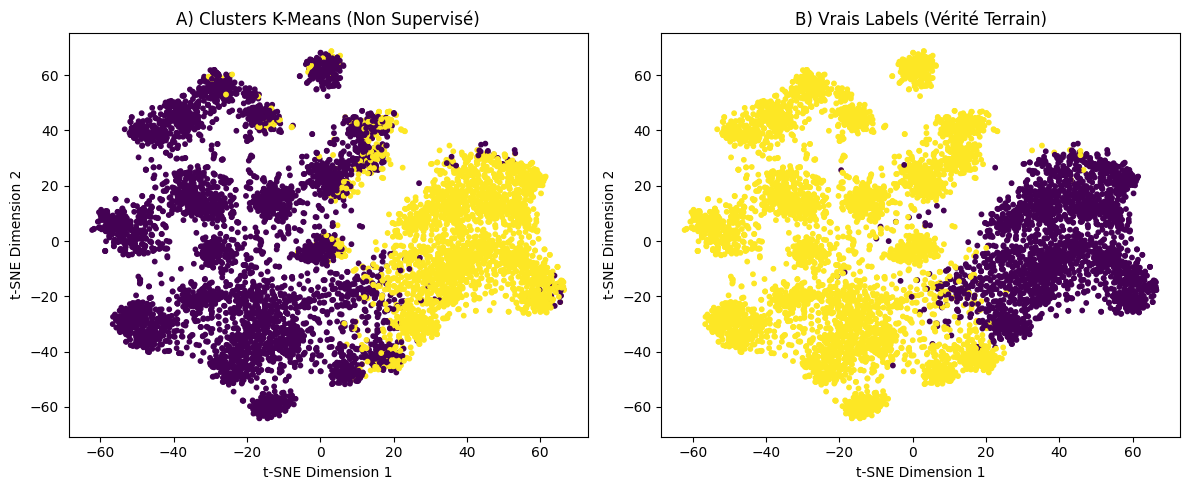

In [ ]:

print(f"2. Application de K-Means (K={N_CLUSTERS}) pour le clustering...")
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=100, random_state=42)
kmeans.fit(latents_np)
cluster_labels = kmeans.labels_ 
print("3. Réduction de dimension avec t-SNE pour la visualisation...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latents_2d = tsne.fit_transform(latents_np)

print("4. Vérification et visualisation des clusters...")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('A) Clusters K-Means (Non Supervisé)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

if true_labels is not None:
    plt.subplot(1, 2, 2)
    plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=true_labels.numpy(), cmap='viridis', s=10)
    plt.title('B) Vrais Labels (Vérité Terrain)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    from sklearn.metrics import adjusted_rand_score
    ari_score = adjusted_rand_score(true_labels.numpy(), cluster_labels)
    print(f"\nQualité du Clustering (comparé aux vrais labels - ARI): {ari_score:.4f}")

plt.tight_layout()
plt.show()


In [ ]:
import torch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
import numpy as np


latents_np = latents_tensor.numpy()

N_CLUSTERS = 2

print("Application de l'Agglomerative Clustering (Linkage: Ward)...")


agg_clustering = AgglomerativeClustering(
    n_clusters=N_CLUSTERS,
    linkage='ward'
)

cluster_labels_agg = agg_clustering.fit_predict(latents_np)

print(f"Clustering terminé. {len(cluster_labels_agg)} échantillons classés en 2 clusters.")


if true_labels is not None:
    true_labels_np = true_labels.numpy()
    ari_score_agg = adjusted_rand_score(true_labels_np, cluster_labels_agg)

    print(f"\n--- Score de Performance ---")
    print(f"Adjusted Rand Index (ARI) avec Agglomerative Clustering : {ari_score_agg:.4f}")

Application de l'Agglomerative Clustering (Linkage: Ward)...
Clustering terminé. 7349 échantillons classés en 2 clusters.

--- Score de Performance ---
Adjusted Rand Index (ARI) avec Agglomerative Clustering : 0.8979


Calcul de la réduction de dimension t-SNE (cela peut prendre quelques minutes)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Calcul t-SNE terminé.


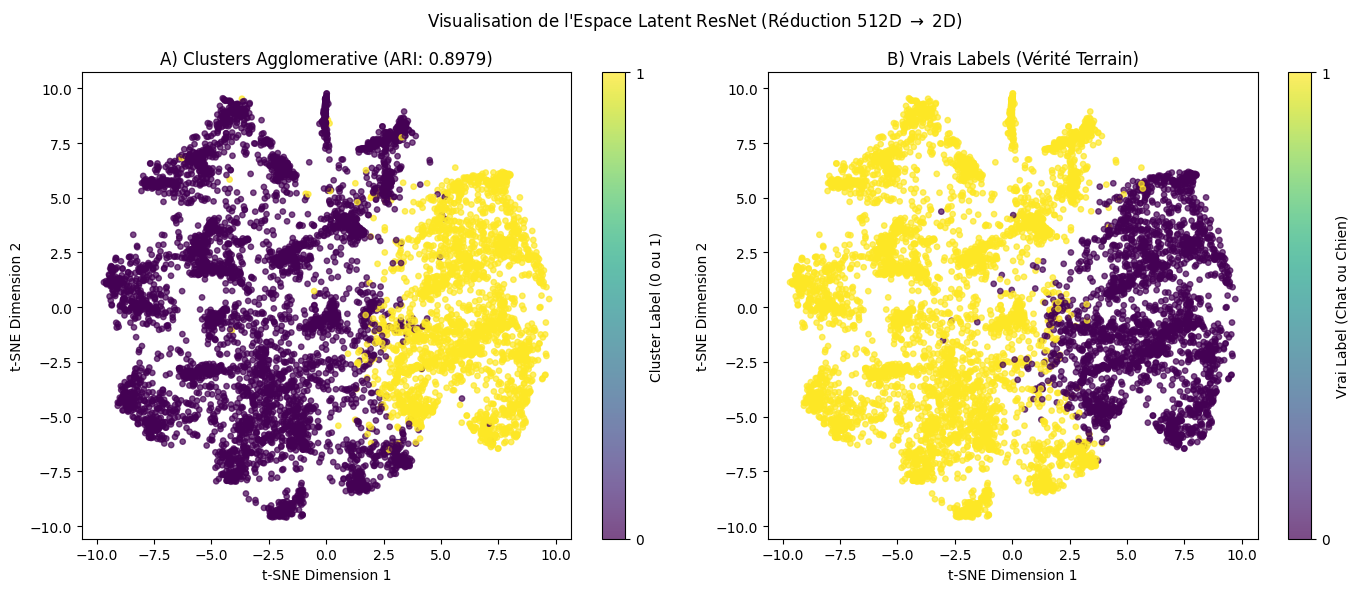

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


print("Calcul de la réduction de dimension t-SNE (cela peut prendre quelques minutes)...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
latents_2d = tsne.fit_transform(latents_np)

print("Calcul t-SNE terminé.")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(
    latents_2d[:, 0],
    latents_2d[:, 1],
    c=cluster_labels_agg,
    cmap='viridis',
    s=15,
    alpha=0.7
)
plt.title(f'A) Clusters Agglomerative (ARI: {np.round(adjusted_rand_score(true_labels_np, cluster_labels_agg), 4)})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter1, ticks=[0, 1], label='Cluster Label (0 ou 1)')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(
    latents_2d[:, 0],
    latents_2d[:, 1],
    c=true_labels_np,
    cmap='viridis',
    s=15,
    alpha=0.7
)
plt.title('B) Vrais Labels (Vérité Terrain)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter2, ticks=[0, 1], label='Vrai Label (Chat ou Chien)')

plt.suptitle('Visualisation de l\'Espace Latent ResNet (Réduction 512D $\\to$ 2D)')
plt.tight_layout()
plt.savefig("agglomerative_clustering_tsne_visualization.png")
plt.show()